In [1]:
import pickle
import joblib
import sklearn
import random
import os
import pandas as pd
import numpy as np

from src.pipelines.magic_loop import load_transformation, filter_drop, \
                                      transformation_pipeline, train_test_split, NUM_VARS, CAT_VARS

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
sklearn.__version__

'0.23.2'

In [3]:
os.chdir("..")

In [4]:
path = os.getcwd()
path

'/home/carotova/Documents/MCD/Intro_DS/accidentes-viales-CDMX'

In [5]:
joblib.__version__

'0.16.0'

In [6]:
df = load_transformation(path)

Opening feature engineering pickle from output path
Feature Engineering pickle successfully retrieved.


In [12]:
# Load all X_train, y_train, X_test, y test
X_train = pickle.load(open("output/X_train.pkl", 'rb'))
y_train = pickle.load(open("output/Y_train.pkl", 'rb'))
X_test = pickle.load(open("output/X_test.pkl", 'rb'))
y_test = pickle.load(open("output/Y_test.pkl", 'rb'))

In [13]:
X_train.shape

(967884, 36)

In [15]:
y_train.shape

(967884,)

In [16]:
X_test.shape

(414808, 36)

In [17]:
y_test.shape

(414808,)

# Random Forest

In [61]:
path = "output/random_forest.joblib"
model = joblib.load(path)

In [62]:
model

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=RandomForestClassifier(oob_score=1, random_state=1789),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 400]},
             scoring='precision')

In [63]:
model.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [19]:
# predicciones con el mejor predictor 
predicted_labels = model.predict(X_test)

In [22]:
predicted_labels.shape

(414808,)

In [24]:
# predicciones en score con el mejor predictor
predicted_scores = model.predict_proba(X_test)

In [25]:
predicted_scores.shape

(414808, 2)

## ROC

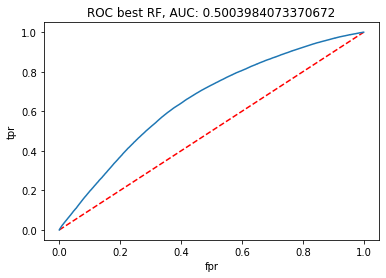

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusión

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[333679,    196],
       [ 80821,    112]])

## Precision, recall, thresholds

In [29]:

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [30]:
thresholds_2 = np.append(thresholds_2, 1)

In [31]:
(precision.shape, recall.shape, thresholds_2.shape)

((192424,), (192424,), (192424,))

In [32]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [33]:
from sklearn.metrics import recall_score
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [35]:
def get_top_k(y_scores, k):
    pass

In [36]:
def pr_k_curve(y_true, y_scores, save_target=None):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k = get_top_k(y_scores, k)
        #top_k = y_scores
        # print(precision_at_k(y_true, y_scores, k))
        d['precision'] = precision_at_k(y_true, y_scores, k)#(top_k)
        d['recall'] = recall_at_k(y_true, y_scores, k)#(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)
    else:
        plt.show

    return pr_k

In [38]:
k = 20
precision_at_k(predicted_labels, y_test, 0.1)

0.0013838607243028185

In [39]:
recall_at_k(predicted_labels, y_test, 0.1)

0.36363636363636365

In [50]:
pr_k_curve(predicted_labels, y_test)

IndexError: index 414808 is out of bounds for axis 0 with size 414808

## Reporte de métricas

In [40]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [41]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.018169,0.195115,1.000000,0.326520,1.000000,0.999967,0.000033,0.000000
1,0.018329,0.195114,0.999988,0.326519,0.999988,0.999958,0.000042,0.000012
2,0.018973,0.195117,0.999988,0.326523,0.999988,0.999940,0.000060,0.000012
3,0.019026,0.195118,0.999988,0.326525,0.999988,0.999931,0.000069,0.000012
4,0.019198,0.195120,0.999988,0.326527,0.999988,0.999922,0.000078,0.000012
...,...,...,...,...,...,...,...,...
136920,0.641095,0.428571,0.000037,0.000074,0.000037,0.000012,0.999988,0.999963
136921,0.643071,0.500000,0.000037,0.000074,0.000037,0.000009,0.999991,0.999963
136922,0.657500,0.250000,0.000012,0.000025,0.000012,0.000009,0.999991,0.999988
136923,0.665833,0.333333,0.000012,0.000025,0.000012,0.000006,0.999994,0.999988


¿Qué métrica escogemos?

In [42]:
negocio = metrics_report[metrics_report.fpr <= 0.06]

In [43]:
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
126467,0.352500,0.325510,0.119444,0.174761,0.119444,0.059996,0.940004,0.880556
126468,0.352504,0.325521,0.119444,0.174763,0.119444,0.059993,0.940007,0.880556
126469,0.352506,0.325520,0.119432,0.174749,0.119432,0.059987,0.940013,0.880568
126470,0.352520,0.325485,0.119395,0.174705,0.119395,0.059978,0.940022,0.880605
126471,0.352527,0.325507,0.119395,0.174708,0.119395,0.059972,0.940028,0.880605
...,...,...,...,...,...,...,...,...
136920,0.641095,0.428571,0.000037,0.000074,0.000037,0.000012,0.999988,0.999963
136921,0.643071,0.500000,0.000037,0.000074,0.000037,0.000009,0.999991,0.999963
136922,0.657500,0.250000,0.000012,0.000025,0.000012,0.000009,0.999991,0.999988
136923,0.665833,0.333333,0.000012,0.000025,0.000012,0.000006,0.999994,0.999988


Matriz asociada a este punto de corte

In [44]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.3525001595986071

In [45]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [47]:
pd.Series(new_labels).sum()

29698

In [48]:
confusion_matrix(y_test, new_labels)

array([[313844,  20031],
       [ 71266,   9667]])

In [49]:
confusion_matrix(y_test, predicted_labels)

array([[333679,    196],
       [ 80821,    112]])

# Decision Tree

In [64]:
path = "output/decision_tree.joblib"
model = joblib.load(path)

In [65]:
model

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=DecisionTreeClassifier(random_state=1789), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 3, 5]},
             scoring='precision')

In [66]:
model.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [67]:
# predicciones con el mejor predictor 
predicted_labels = model.predict(X_test)

In [68]:
predicted_labels.shape

(414808,)

In [69]:
# predicciones en score con el mejor predictor
predicted_scores = model.predict_proba(X_test)

In [70]:
predicted_scores.shape

(414808, 2)

## ROC

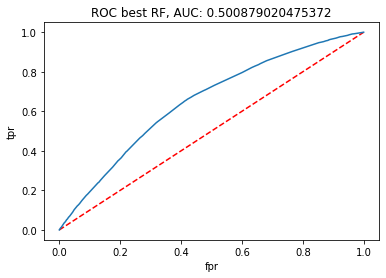

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusión

In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[333311,    564],
       [ 80654,    279]])

## Precision, recall, thresholds

In [73]:

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [74]:
thresholds_2 = np.append(thresholds_2, 1)

In [75]:
(precision.shape, recall.shape, thresholds_2.shape)

((440,), (440,), (440,))

In [76]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [77]:
from sklearn.metrics import recall_score
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [78]:
def get_top_k(y_scores, k):
    pass

In [79]:
def pr_k_curve(y_true, y_scores, save_target=None):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k = get_top_k(y_scores, k)
        #top_k = y_scores
        # print(precision_at_k(y_true, y_scores, k))
        d['precision'] = precision_at_k(y_true, y_scores, k)#(top_k)
        d['recall'] = recall_at_k(y_true, y_scores, k)#(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)
    else:
        plt.show

    return pr_k

In [80]:
k = 20
precision_at_k(predicted_labels, y_test, 0.1)

0.0034472959114329135

In [81]:
recall_at_k(predicted_labels, y_test, 0.1)

0.3309608540925267

In [50]:
pr_k_curve(predicted_labels, y_test)

IndexError: index 414808 is out of bounds for axis 0 with size 414808

## Reporte de métricas

In [82]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [83]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.000000,0.195110,1.000000,0.326513,1.000000,1.000000,0.000000,0.000000
1,0.007812,0.195272,0.999333,0.326705,0.999333,0.998302,0.001698,0.000667
2,0.009174,0.195281,0.999283,0.326716,0.999283,0.998191,0.001809,0.000717
3,0.011209,0.195292,0.999271,0.326729,0.999271,0.998113,0.001887,0.000729
4,0.011396,0.195482,0.999073,0.326986,0.999073,0.996705,0.003295,0.000927
...,...,...,...,...,...,...,...,...
435,0.833333,0.269841,0.000210,0.000420,0.000210,0.000138,0.999862,0.999790
436,0.857143,0.200000,0.000111,0.000222,0.000111,0.000108,0.999892,0.999889
437,0.875000,0.179487,0.000086,0.000173,0.000086,0.000096,0.999904,0.999914
438,1.000000,0.172414,0.000062,0.000124,0.000062,0.000072,0.999928,0.999938


¿Qué métrica escogemos?

In [84]:
negocio = metrics_report[metrics_report.fpr <= 0.06]

In [85]:
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
352,0.365591,0.332101,0.122089,0.178541,0.122089,0.059519,0.940481,0.877911
353,0.365632,0.332311,0.121829,0.178294,0.121829,0.059337,0.940663,0.878171
354,0.368421,0.336390,0.101998,0.156533,0.101998,0.048776,0.951224,0.898002
355,0.373832,0.336310,0.101924,0.156437,0.101924,0.048758,0.951242,0.898076
356,0.375000,0.336812,0.101689,0.156214,0.101689,0.048536,0.951464,0.898311
...,...,...,...,...,...,...,...,...
435,0.833333,0.269841,0.000210,0.000420,0.000210,0.000138,0.999862,0.999790
436,0.857143,0.200000,0.000111,0.000222,0.000111,0.000108,0.999892,0.999889
437,0.875000,0.179487,0.000086,0.000173,0.000086,0.000096,0.999904,0.999914
438,1.000000,0.172414,0.000062,0.000124,0.000062,0.000072,0.999928,0.999938


Matriz asociada a este punto de corte

In [86]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.3655913978494624

In [87]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [88]:
pd.Series(new_labels).sum()

29753

In [89]:
confusion_matrix(y_test, new_labels)

array([[314003,  19872],
       [ 71052,   9881]])

In [90]:
confusion_matrix(y_test, predicted_labels)

array([[333311,    564],
       [ 80654,    279]])